## Spectrum Simulation Example

In this example, we will simulate the NMR spectrum of a Pyridine molecule.

- **Molecule and Spins**: The simulation incorporates only the 5 protons of the Pyridine molecule.

- **Interactions Included**:
    - **Coherent Interactions**:
        - Zeeman interaction.
        - Chemical shift.
        - Scalar $J$-coupling.
    - **Incoherent Interactions**:
        - Dipolar coupling.

This example provides an overview of how to simulate NMR spectra using Spinguin.

### Imports

To begin, we import all the necessary modules.

- **NumPy**: Used for creating arrays required for input parameters and storing results.
- **Matplotlib**: Utilized for plotting the simulation results.
- **Spinguin**: Provides specialized functionality for simulating NMR experiments.

In [1]:
# Import necessary modules:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from spinguin import SpinSystem, hamiltonian, relaxation,\
                     equilibrium_state, measure, propagator,\
                     pulse, spectrum, spectrum_timestep,\
                     frequency_to_chemical_shift

### Simulation Parameters

The following simulation parameters are defined:

- **Magnetic Field (T)**: The strength of the static magnetic field $B_0$.
- **Rotational Correlation Time (ps)**: The characteristic time for molecular tumbling, affecting relaxation processes.
- **Temperature (K)**: The temperature at which the simulation is conducted.

In [2]:
# Define simulation parameters:
B0 = 9.4 # Tesla
tau_c = 50e-12 # 50 picoseconds
T = 295 # Kelvin

### Define the Spin System

To define the spin system, we need to specify the following parameters:

- **Isotopes**: The types of nuclei in the system.
- **Chemical Shifts (ppm)**: The chemical shifts for each nucleus.
- **J Couplings (Hz)**: The $J$-coupling constants between nuclei.
- **XYZ Coordinates (Å)**: The spatial positions of the nuclei in Cartesian coordinates.

These parameters are defined as NumPy arrays and provided as input when creating the spin system object.

In [3]:
# Define the spin system parameters:
isotopes = np.array(['1H', '1H', '1H', '1H', '1H'])
chemical_shifts = np.array([8.56, 8.56, 7.47, 7.47, 7.88])

J_couplings = np.array([
    [ 0,     0,      0,      0,      0],
    [-1.04,  0,      0,      0,      0],
    [ 4.85,  1.05,   0,      0,      0],
    [ 1.05,  4.85,   0.71,   0,      0],
    [ 1.24,  1.24,   7.55,   7.55,   0]
])
xyz = np.array([
    [ 2.0495335,  0.0000000, -1.4916842],
    [-2.0495335,  0.0000000, -1.4916842],
    [ 2.1458878,  0.0000000,  0.9846086],
    [-2.1458878,  0.0000000,  0.9846086],
    [ 0.0000000,  0.0000000,  2.2681296]
])
shielding = np.zeros((5, 3, 3)) # TODO: Remove
efg = np.zeros((5, 3, 3)) # TODO: Remove

# Create the spin system object with the defined parameters.
# The maximum spin order is limited to 3 to enhance computational performance.
spin_system = SpinSystem(
    isotopes, 
    chemical_shifts, 
    J_couplings, 
    xyz, 
    shielding, # TODO: Remove
    efg, # TODO: Remove
    max_spin_order=5,
)

### Calculate Hamiltonian and Relaxation Superoperators

To perform the time evolution of the spin system under the NMR interactions described by the Liouvillian, we need to calculate the following:

- **Hamiltonian**: Represents the coherent interactions in the system.
- **Relaxation Superoperator**: Accounts for the incoherent interactions and the resulting relaxation processes.

In [4]:
# Calculate the Hamiltonian for the spin system.
H = hamiltonian(spin_system, B0)

# Calculate the relaxation superoperator for the spin system.
R = relaxation(spin_system, H, B0, tau_c)

Constructing Hamiltonian...
Hamiltonian constructed in 0.2107 seconds.

Constructing relaxation superoperator...
Processing rank l=1, projection q=0
Processing rank l=1, projection q=1
Processing rank l=2, projection q=0
DD for spins 1-0
DD for spins 2-0
DD for spins 2-1
DD for spins 3-0
DD for spins 3-1
DD for spins 3-2
DD for spins 4-0
DD for spins 4-1
DD for spins 4-2
DD for spins 4-3
Processing rank l=2, projection q=1
DD for spins 1-0
DD for spins 2-0
DD for spins 2-1
DD for spins 3-0
DD for spins 3-1
DD for spins 3-2
DD for spins 4-0
DD for spins 4-1
DD for spins 4-2
DD for spins 4-3
Processing rank l=2, projection q=2
DD for spins 1-0
DD for spins 2-0
DD for spins 2-1
DD for spins 3-0
DD for spins 3-1
DD for spins 3-2
DD for spins 4-0
DD for spins 4-1
DD for spins 4-2
DD for spins 4-3
Relaxation superoperator constructed in 1.3662 seconds.



### Thermal Equilibrium

To compute the NMR spectrum, we need the thermal equilibrium state.

- The thermal equilibrium state represents the natural distribution of spin populations in the presence of an external magnetic field at a given temperature.
- We create a state vector corresponding to this thermal equilibrium, which serves as the starting point for the simulation.

In [5]:
# Initialize the state vector to thermal equilibrium.
rho = equilibrium_state(spin_system, T, B0)

### Apply 90-Degree Pulse

The spectral simulation begins with a 90-degree pulse.

- The 90-degree pulse is applied along the $y$-axis to selected protons (spins with indices 0 to 3).
- This pulse is essentially a rotation operator that tips the magnetization of the selected spins into the transverse plane.
- The pulse is applied by multiplying the state vector with the rotation operator.

In [6]:
# Apply a 90-degree pulse along the y-axis to the protons (spins with indices 0 to 4).
pulse_str = 'I(y,0) + I(y,1) + I(y,2) + I(y,3) + I(y,4)'
pul_90 = pulse(spin_system, pulse_str, angle=90)

# Update the state vector by applying the 90-degree pulse.
rho = pul_90 @ rho

Creating a pulse superoperator...
Pulse constructed in 0.1902 seconds.



### Construct the Time Propagator

The time propagator is a crucial component for simulating the time evolution of the spin system.

- **Purpose**: The propagator is used to drive the spin system forward in time during the simulation.
- **Construction**: It is constructed using the Hamiltonian and the relaxation superoperator.
- **Time Step**: The propagator is specific to the chosen time step, ensuring accurate simulation of the dynamics.

Note: The simulation is performed in the rotating frame to remove the high-frequency oscillations associated with the bare-nucleus Larmor precession.

In [7]:
# Construct the Liouvillian superoperator.
L = -1j*H - R

# Get the optimal timestep in the rotating frame.
dt = spectrum_timestep(spin_system, B0, rotating_frame=True)

# Construct the propagator in the rotating frame.
P = propagator(L, dt, rotating_frame=True, spin_system=spin_system, B=B0)

Constructing propagator...
Calculating the matrix exponential...
Scaling the matrix down by 1048576.
Calculating the matrix exponential using Taylor series.
Taylor series term: 1
Taylor series term: 2
Taylor series term: 3
Taylor series term: 4
Taylor series term: 5
Taylor series term: 6
Taylor series term: 7
Taylor series term: 8
Taylor series term: 9
Taylor series term: 10
Taylor series term: 11
Taylor series term: 12
Taylor series term: 13
Taylor series term: 14
Taylor series term: 15
Taylor series term: 16
Taylor series term: 17
Taylor series term: 18
Taylor series term: 19
Taylor series term: 20
Taylor series converged.
Squaring the matrix. Step 1 of 20.
Squaring the matrix. Step 2 of 20.
Squaring the matrix. Step 3 of 20.
Squaring the matrix. Step 4 of 20.
Squaring the matrix. Step 5 of 20.
Squaring the matrix. Step 6 of 20.
Squaring the matrix. Step 7 of 20.
Squaring the matrix. Step 8 of 20.
Squaring the matrix. Step 9 of 20.
Squaring the matrix. Step 10 of 20.
Squaring the mat

### Initialize an Empty Array for Storing Results

In this spectrum simulation, we aim to measure the transverse magnetizations of the spins at various time intervals to compute the NMR spectrum.
- **Simulation Approach**: The simulation involves applying a 90-degree pulse and propagating the spin system forward in time. At each time step, the magnetization is "measured" by calculating the expectation value of the specified operator. This corresponds to the quadrature detection.
- **Storage**: To store the magnetizations, we initialize a NumPy array. The array dimensions correspond to:
    - The number of time steps in the simulation.
    - The total magnetization of the spin system.

In [8]:
# Define simulation time and the number time steps
t_max = 25
N_steps = int(t_max / dt)

# Initialize an array to store the sum transverse magnetization of the spins.
magnetizations = np.zeros(N_steps, dtype=complex)

### Perform the Time Evolution

We are now ready to perform the time evolution of the spin system.

- **Loop Over Time Steps**: Iterate through the total number of time steps defined for the simulation.
- **Propagate the System**: At each time step, propagate the spin system forward in time using the time propagator.
- **Measure Magnetization**: For each proton (spins with indices 0 to 4), measure the total transverse magnetization ($\hat S_- = \hat S_x -i\hat S_y$) and store the results in the `magnetizations` array.

In [9]:
# Define the measurement operator for the simulation.
measurement_str = 'I(-,0) + I(-,1) + I(-,2) + I(-,3) + I(-,4)'

# Perform the time evolution of the spin system with a progress bar.
for step in tqdm(range(N_steps), desc="Simulating Time Evolution"):
    
    # Perform the quadrature detection of the transverse magnetization.
    magnetizations[step] += measure(spin_system, rho, measurement_str)

    # Propagate the state vector to the next time step.
    rho = P @ rho

Simulating Time Evolution: 100%|██████████| 328923/328923 [01:07<00:00, 4875.44it/s]


### Perform the Fourier Transform to Obtain the Spectrum

- **Fourier Transform**: We then take the Fourier transform of the magnetization data to get the NMR spectrum.
- **Frequency to Chemical Shift Conversion**: The frequency axis is converted to chemical shifts in ppm for better interpretability of the spectrum.

In [10]:
# Compute the real part of the spectrum.
freqs, spec = spectrum(magnetizations, dt)

# Set the spectrometer frequency to the Larmor frequency of protons.
freq_spectrometer = -spin_system.gammas[0] * B0 / (2 * np.pi)

# Convert frequencies to chemical shifts
chemical_shifts = frequency_to_chemical_shift(freqs, 0, freq_spectrometer)

### Plot the Results

Congratulations! The simulation is complete. We will then plot the results.

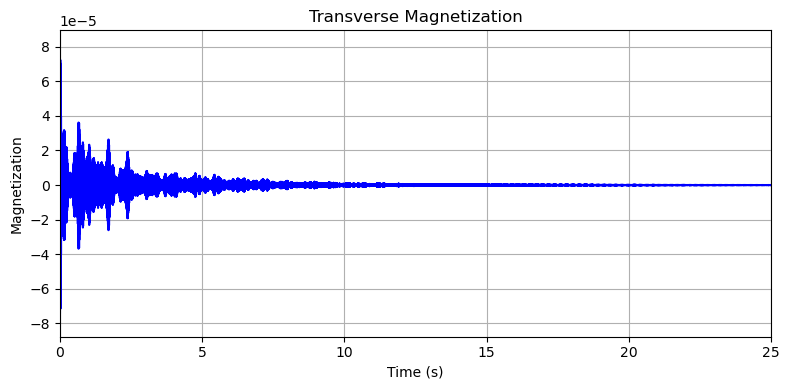

In [11]:
# Plot the magnetization over time
t_axis = np.arange(0, N_steps) * dt
plt.figure(figsize=(8, 4))
plt.plot(t_axis, np.real(magnetizations), color='blue')
plt.title('Transverse Magnetization')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization')
plt.grid()
plt.xlim(0, t_max)
plt.tight_layout()
plt.show()

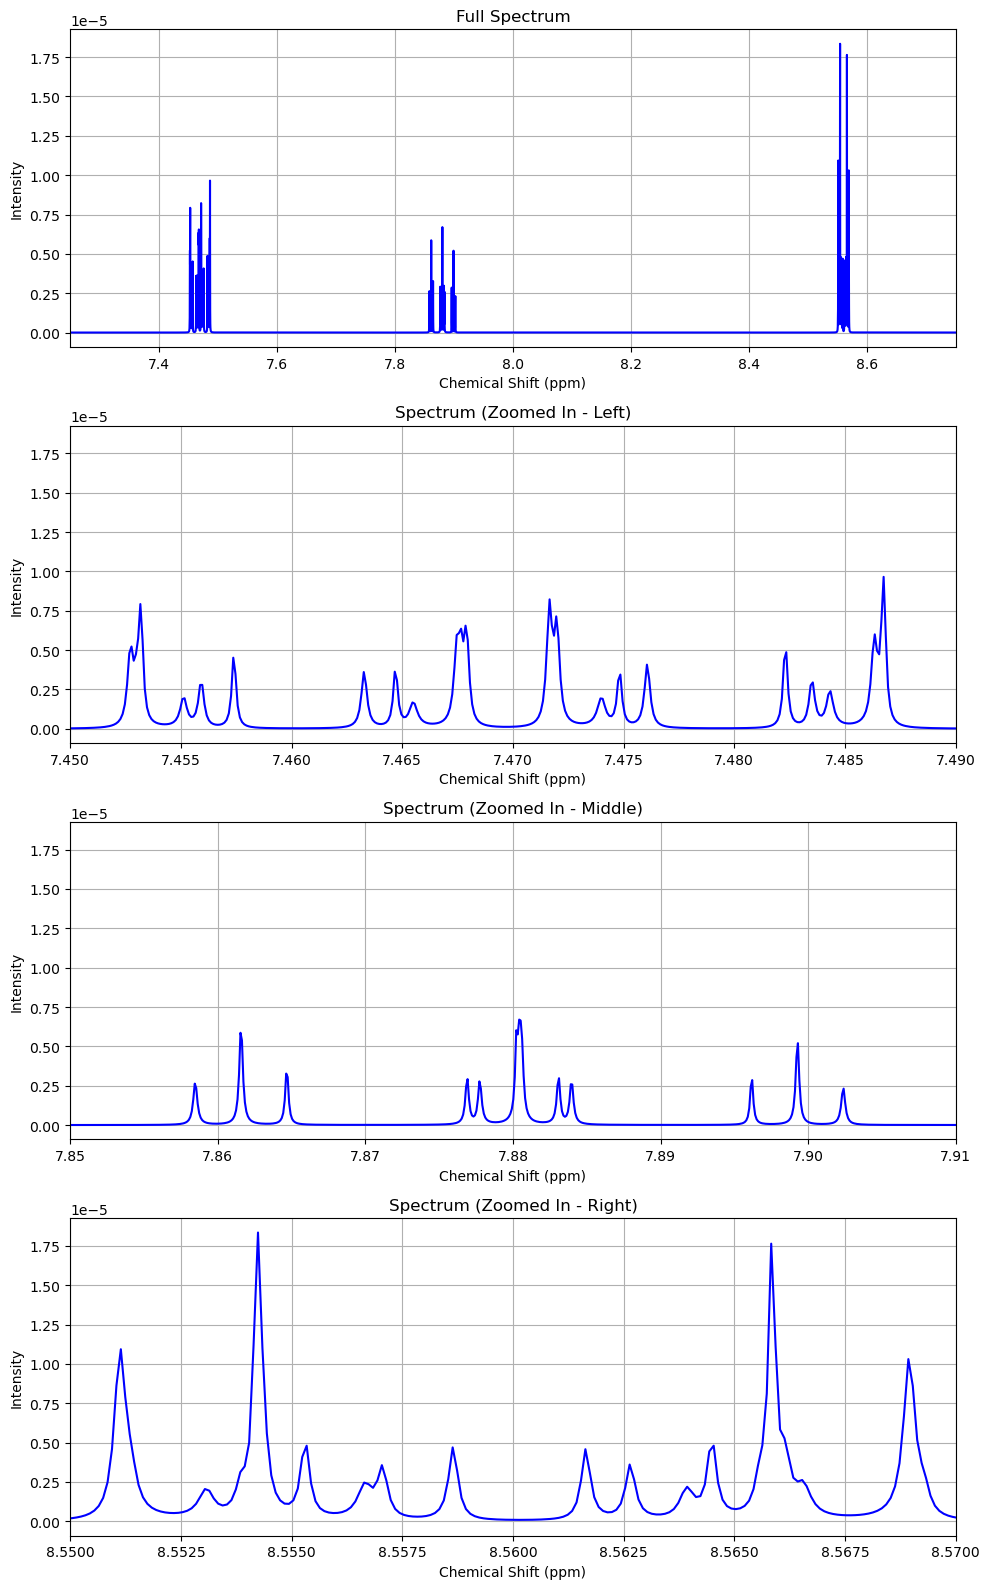

In [12]:
# Create a figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 16), gridspec_kw={'height_ratios': [1, 1, 1, 1]})

# Plot the full spectrum on the top
axes[0].plot(chemical_shifts, spec, color='blue')
axes[0].set_title('Full Spectrum')
axes[0].set_xlabel('Chemical Shift (ppm)')
axes[0].set_ylabel('Intensity')
axes[0].grid()
axes[0].set_xlim(7.25, 8.75)

# Plot the zoomed-in spectrum (left) in the second subplot
axes[1].plot(chemical_shifts, spec, color='blue')
axes[1].set_title('Spectrum (Zoomed In - Left)')
axes[1].set_xlabel('Chemical Shift (ppm)')
axes[1].set_ylabel('Intensity')
axes[1].grid()
axes[1].set_xlim(7.45, 7.49)

# Plot the zoomed-in spectrum (middle) in the third subplot
axes[2].plot(chemical_shifts, spec, color='blue')
axes[2].set_title('Spectrum (Zoomed In - Middle)')
axes[2].set_xlabel('Chemical Shift (ppm)')
axes[2].set_ylabel('Intensity')
axes[2].grid()
axes[2].set_xlim(7.85, 7.91)

# Plot the zoomed-in spectrum (right) at the bottom
axes[3].plot(chemical_shifts, spec, color='blue')
axes[3].set_title('Spectrum (Zoomed In - Right)')
axes[3].set_xlabel('Chemical Shift (ppm)')
axes[3].set_ylabel('Intensity')
axes[3].grid()
axes[3].set_xlim(8.55, 8.57)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()